## Table of Contents

### 1. Data Loading and Preprocessing 
> #### 1.1 Load the Data
> #### 1.2 Define custom dataset and dataloader
> #### 1.3 Data Exploration
### 2. Image Generation using DC-GAN
> #### 2.1 Define model architecture
> #### 2.2 Train the model
> #### 2.3 Generate random images


---

### 1. Data Loading and Preprocessing

#### 1.1 Load the Data

In [1]:
# # Upload data from drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# # get images
!unzip /content/drive/MyDrive/images_dtd-200713-114828.zip

Archive:  /content/drive/MyDrive/images_dtd-200713-114828.zip
  inflating: images_dtd/banded_0002.jpg  
  inflating: images_dtd/banded_0004.jpg  
  inflating: images_dtd/banded_0005.jpg  
  inflating: images_dtd/banded_0006.jpg  
  inflating: images_dtd/banded_0008.jpg  
  inflating: images_dtd/banded_0009.jpg  
  inflating: images_dtd/banded_0010.jpg  
  inflating: images_dtd/banded_0011.jpg  
  inflating: images_dtd/banded_0012.jpg  
  inflating: images_dtd/banded_0013.jpg  
  inflating: images_dtd/banded_0016.jpg  
  inflating: images_dtd/banded_0019.jpg  
  inflating: images_dtd/banded_0021.jpg  
  inflating: images_dtd/banded_0022.jpg  
  inflating: images_dtd/banded_0023.jpg  
  inflating: images_dtd/banded_0024.jpg  
  inflating: images_dtd/banded_0025.jpg  
  inflating: images_dtd/banded_0030.jpg  
  inflating: images_dtd/banded_0033.jpg  
  inflating: images_dtd/banded_0034.jpg  
  inflating: images_dtd/banded_0036.jpg  
  inflating: images_dtd/banded_0037.jpg  
  inflating: i

In [3]:
!pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# import libraries and modules
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pytorch_model_summary import summary

# import pytorch related modules
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, RandomCrop, Normalize

from torch.optim import Adam

from torch.nn import Sequential
from torch.nn import Linear, LeakyReLU, BatchNorm2d, Sigmoid, Tanh, Flatten, BCELoss, Conv2d, ConvTranspose2d, ReLU

from torch.nn.init import normal_, constant_

In [5]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [6]:
images_dir = "/content/images_dtd"

In [7]:
# define custom dataset class
class TextureDataset(Dataset):
    def __init__(self, images_dir):

        # get all image names
        self.image_names = os.listdir(images_dir)
        
        # get image paths
        self.images_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
    
    def __getitem__(self, idx):
        
        # read data
        image = Image.open(self.images_paths[idx])

        # apply data augmentation
        transform = Compose([
                    Resize(80),
                    RandomCrop(64),
                    ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
        
        image = transform(image)
        
        return image
        
    def __len__(self):
        return len(self.image_names)

In [8]:
# create instance of custom dataset
dataset = TextureDataset(images_dir)

# create dataloader
data_loader = DataLoader(
    dataset, 
    batch_size=64,
    num_workers=4,
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
# check for one iteration of loop
for batch_x in data_loader:
    break

In [10]:
# get shapes of batches
batch_x.shape

torch.Size([64, 3, 64, 64])

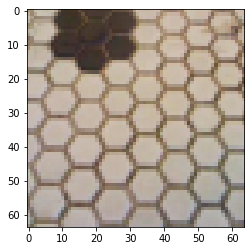

In [ ]:
# print image
image = (batch_x[0] + 1) / 2
image = np.transpose(image, (1, 2, 0))
plt.imshow(image)

In [ ]:
batch_x.min(), batch_x.max()

(tensor(-1.), tensor(1.))

### 2. Image Generation using DC-GAN

#### 2.1 Define model architecture

Define discriminator model architecture:

Input

Conv(num_filters=16, filter_size=4, stride=2, padding=1, activation='leaky_relu')

Conv(num_filters=32, filter_size=4, stride=2, padding=1, activation='leaky_relu')

BatchNorm()

Conv(num_filters=64, filter_size=4, stride=2, padding=1, activation='leaky_relu')

BatchNorm()

Conv(num_filters=128, filter_size=4, stride=2, padding=1, activation='leaky_relu')

BatchNorm()

Conv(num_filters=1, filter_size=4, stride=2, padding=1, activation='sigmoid')

In [12]:


discriminator = Sequential(
    Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
    LeakyReLU(0.2),
    Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(128),
    LeakyReLU(0.2),
    Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    Sigmoid()
)

In [13]:
print(summary(discriminator, batch_x[:1]))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 16, 32, 32]             768             768
       LeakyReLU-2     [1, 16, 32, 32]               0               0
          Conv2d-3     [1, 32, 16, 16]           8,192           8,192
     BatchNorm2d-4     [1, 32, 16, 16]              64              64
       LeakyReLU-5     [1, 32, 16, 16]               0               0
          Conv2d-6       [1, 64, 8, 8]          32,768          32,768
     BatchNorm2d-7       [1, 64, 8, 8]             128             128
       LeakyReLU-8       [1, 64, 8, 8]               0               0
          Conv2d-9      [1, 128, 4, 4]         131,072         131,072
    BatchNorm2d-10      [1, 128, 4, 4]             256             256
      LeakyReLU-11      [1, 128, 4, 4]               0               0
         Conv2d-12        [1, 1, 1, 1]           2,048           2,048
     

In [14]:
# check model on one image
output = discriminator(batch_x[:1]).detach().numpy()

In [15]:
output

array([[[[0.54384655]]]], dtype=float32)

Define generator model architecture

Input

ConvTranspose(num_filters=128, filter_size=4, stride=1, padding=0, activation='leaky_relu')

BatchNorm()

ConvTranspose(num_filters=64, filter_size=4, stride=2, padding=1, activation='leaky_relu')

BatchNorm()

ConvTranspose(num_filters=32, filter_size=4, stride=2, padding=1, activation='leaky_relu')

BatchNorm()

ConvTranspose(num_filters=16, filter_size=4, stride=2, padding=1, activation='leaky_relu')

BatchNorm()

ConvTranspose(num_filters=3, filter_size=4, stride=2, padding=1, activation='tanh')

In [16]:


generator = Sequential(
    ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
    BatchNorm2d(128),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(16),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    Tanh()
)

In [17]:
print(summary(generator, torch.randn(1, 100, 1, 1)))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
    ConvTranspose2d-1      [1, 128, 4, 4]         204,800         204,800
        BatchNorm2d-2      [1, 128, 4, 4]             256             256
          LeakyReLU-3      [1, 128, 4, 4]               0               0
    ConvTranspose2d-4       [1, 64, 8, 8]         131,072         131,072
        BatchNorm2d-5       [1, 64, 8, 8]             128             128
          LeakyReLU-6       [1, 64, 8, 8]               0               0
    ConvTranspose2d-7     [1, 32, 16, 16]          32,768          32,768
        BatchNorm2d-8     [1, 32, 16, 16]              64              64
          LeakyReLU-9     [1, 32, 16, 16]               0               0
   ConvTranspose2d-10     [1, 16, 32, 32]           8,192           8,192
       BatchNorm2d-11     [1, 16, 32, 32]              32              32
         LeakyReLU-12     [1, 16, 32,

In [18]:
generator

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2)
  (12): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [23]:
# check model on one image (ramdomly generated)
generator.eval()
output = generator(torch.randn(1, 100, 1, 1)).detach().numpy()

In [24]:
output.shape

(1, 3, 64, 64)

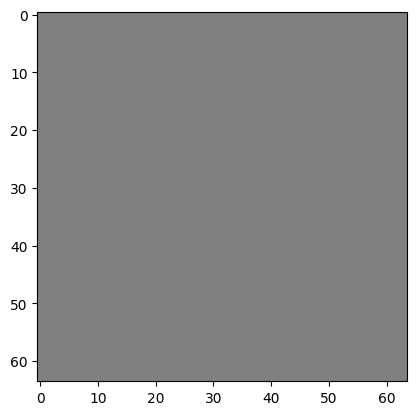

In [26]:
# print image
image = (output + 1) / 2      # change values in image fr0m (-1 to 1) to (0 to 1)
image = np.transpose(image.squeeze(), (1, 2, 0))
plt.imshow(image)

In [27]:
# custom weights initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        normal_(m.weight.data, 0.0, 0.02)            # initiated weights with normal distribution with mean=0 and SD=0.02
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight.data, 1.0, 0.02)
        constant_(m.bias.data, 0)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)
generator.apply(weights_init);

#### 2.2 Train the model

In [28]:
discriminator = discriminator.to('cuda')
generator = generator.to('cuda')

In [41]:
# Initialize BCELoss function
criterion = BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# fixed noise for plotting
fixed_noise = torch.randn(1, 100, 1, 1)

# number of epochs
num_epochs = 50

# Setup Adam optimizers for both G and D
optimizerD = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))

Training loss for epoch 1 is 1.40481 for disciminator and 1.14648 for generator
Training loss for epoch 2 is 1.35880 for disciminator and 1.12206 for generator
Training loss for epoch 3 is 1.36061 for disciminator and 0.95886 for generator
Training loss for epoch 4 is 1.35119 for disciminator and 0.90286 for generator
Training loss for epoch 5 is 1.39584 for disciminator and 0.89391 for generator

Generated Image


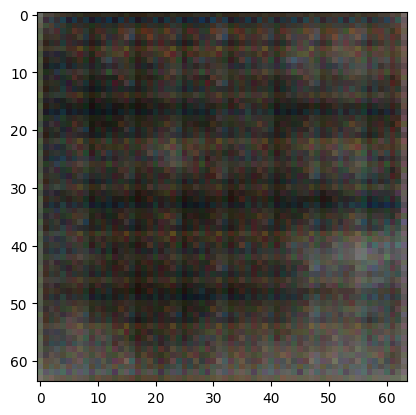

Training loss for epoch 6 is 1.31796 for disciminator and 0.86534 for generator
Training loss for epoch 7 is 1.17266 for disciminator and 1.25451 for generator
Training loss for epoch 8 is 1.25658 for disciminator and 1.13143 for generator
Training loss for epoch 9 is 1.28622 for disciminator and 1.01588 for generator
Training loss for epoch 10 is 1.11162 for disciminator and 1.33341 for generator

Generated Image


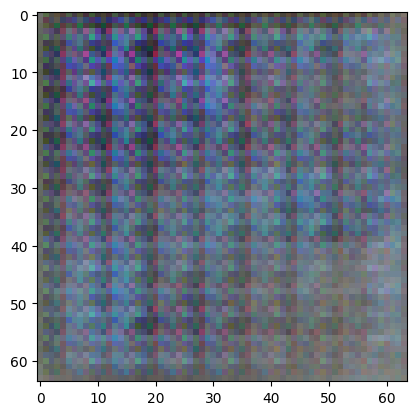

Training loss for epoch 11 is 1.14063 for disciminator and 1.32810 for generator
Training loss for epoch 12 is 1.25597 for disciminator and 1.21993 for generator
Training loss for epoch 13 is 1.13918 for disciminator and 1.31474 for generator
Training loss for epoch 14 is 1.10377 for disciminator and 1.39419 for generator
Training loss for epoch 15 is 1.09974 for disciminator and 1.40799 for generator

Generated Image


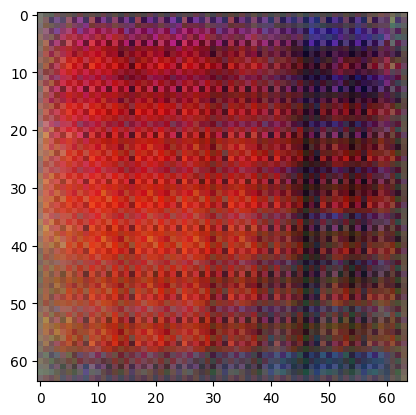

Training loss for epoch 16 is 1.17492 for disciminator and 1.32177 for generator
Training loss for epoch 17 is 1.18527 for disciminator and 1.33857 for generator
Training loss for epoch 18 is 1.10853 for disciminator and 1.56808 for generator
Training loss for epoch 19 is 0.93316 for disciminator and 1.85389 for generator
Training loss for epoch 20 is 1.15365 for disciminator and 1.40869 for generator

Generated Image


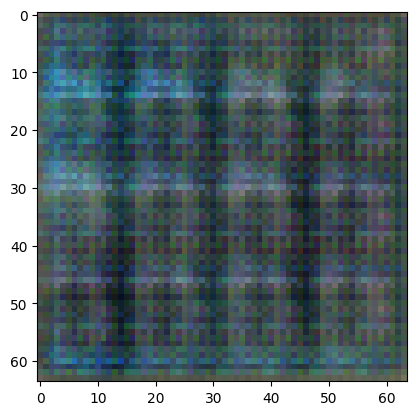

Training loss for epoch 21 is 1.10450 for disciminator and 1.53172 for generator
Training loss for epoch 22 is 1.05396 for disciminator and 1.49837 for generator
Training loss for epoch 23 is 1.18031 for disciminator and 1.21684 for generator
Training loss for epoch 24 is 1.00545 for disciminator and 1.35070 for generator
Training loss for epoch 25 is 1.15758 for disciminator and 1.66602 for generator

Generated Image


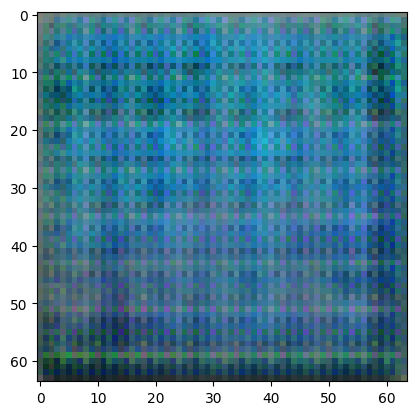

Training loss for epoch 26 is 1.11145 for disciminator and 1.44727 for generator
Training loss for epoch 27 is 1.22200 for disciminator and 1.32153 for generator
Training loss for epoch 28 is 1.08222 for disciminator and 1.50921 for generator
Training loss for epoch 29 is 1.08692 for disciminator and 1.60738 for generator
Training loss for epoch 30 is 0.98892 for disciminator and 1.67666 for generator

Generated Image


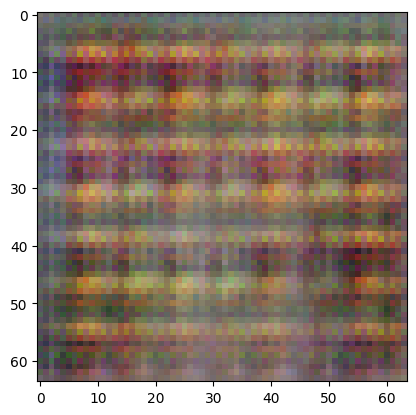

Training loss for epoch 31 is 1.05281 for disciminator and 1.49004 for generator
Training loss for epoch 32 is 0.82367 for disciminator and 2.16248 for generator
Training loss for epoch 33 is 0.86831 for disciminator and 1.87904 for generator
Training loss for epoch 34 is 1.03220 for disciminator and 1.87345 for generator
Training loss for epoch 35 is 1.15244 for disciminator and 1.65823 for generator

Generated Image


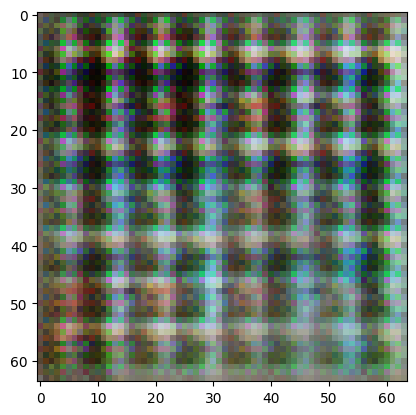

Training loss for epoch 36 is 0.82817 for disciminator and 1.78981 for generator
Training loss for epoch 37 is 1.07797 for disciminator and 1.58724 for generator
Training loss for epoch 38 is 1.05883 for disciminator and 1.69349 for generator
Training loss for epoch 39 is 1.01774 for disciminator and 1.77395 for generator
Training loss for epoch 40 is 0.99328 for disciminator and 1.87181 for generator

Generated Image


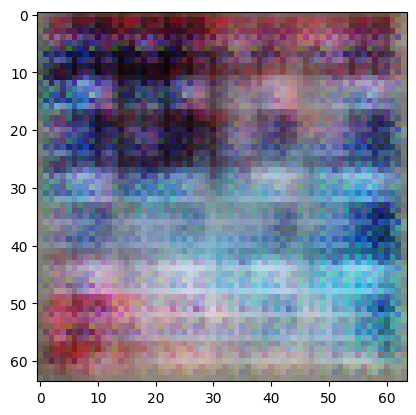

Training loss for epoch 41 is 0.88774 for disciminator and 2.14660 for generator
Training loss for epoch 42 is 0.97377 for disciminator and 1.58657 for generator
Training loss for epoch 43 is 1.04380 for disciminator and 1.72387 for generator
Training loss for epoch 44 is 0.94361 for disciminator and 1.97393 for generator
Training loss for epoch 45 is 0.92130 for disciminator and 1.88946 for generator

Generated Image


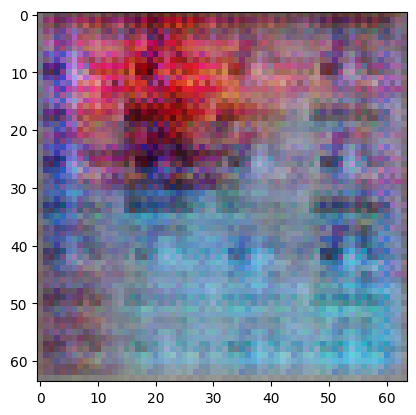

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f59b5dedbd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f59b5dedbd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Training loss for epoch 46 is 0.90441 for disciminator and 2.28693 for generator
Training loss for epoch 47 is 0.96793 for disciminator and 2.04178 for generator
Training loss for epoch 48 is 0.90017 for disciminator and 2.08672 for generator
Training loss for epoch 49 is 0.76131 for disciminator and 2.30823 for generator
Training loss for epoch 50 is 0.87588 for disciminator and 2.21580 for generator

Generated Image


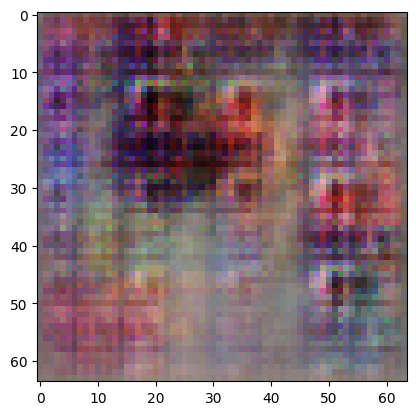

In [42]:
# set model to train
discriminator.train()
generator.train()

# train model
for epoch in range(num_epochs):

    # initialize variables
    epochG_loss = epochD_loss = cnt = 0

    # loop through the data
    for i, batch_x in enumerate(data_loader):
        ## train discriminator

        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()

        batch_size = batch_x.shape[0]

        batch_y = torch.full((batch_size,), real_label, device="cuda")

        # clear gradients
        discriminator.zero_grad()

        # pass images to model
        outputs = discriminator(batch_x).view(-1)

        # get loss
        errD_real = criterion(outputs, batch_y.float())

        # do a backward pass
        errD_real.backward()

        generated_images = generator(torch.randn(batch_size, 100, 1, 1, device="cuda"))

        batch_y = torch.full((batch_size,), fake_label, device="cuda")

        # pass images to model
        outputs = discriminator(generated_images.detach()).view(-1)

        # get loss
        errD_fake = criterion(outputs, batch_y.float())

        # do a backward pass
        errD_fake.backward()

        # update gradients
        optimizerD.step()

        ## train generator

        # clear gradients
        generator.zero_grad()

        batch_y = torch.full((batch_size,), real_label, device="cuda")

        outputs = discriminator(generated_images).view(-1)

        # get loss
        errG = criterion(outputs, batch_y.float())

        # do a backward pass
        errG.backward()

        # add loss
        errD = errD_real + errD_fake

        # update gradients
        optimizerG.step()

        # sum loss and get count
        epochD_loss += errD.item()
        epochG_loss += errG.item()
        cnt += 1

    # take average loss for all batches
    epochD_loss /= cnt
    epochG_loss /= cnt
    
    # print loss
    if (epoch + 1) % 1 == 0:
        print("Training loss for epoch {} is {:.5f} for disciminator and {:.5f} for generator".format(epoch + 1, epochD_loss, epochG_loss))
    if (epoch + 1) % 5 == 0:
        print('\nGenerated Image')

        # get prediction
        generator.eval()
        with torch.no_grad():
            output = generator(fixed_noise.to('cuda')).detach().cpu().numpy()

        # plot generated image
        image = (output + 1) / 2
        image = np.transpose(image.squeeze(), (1, 2, 0))
        plt.imshow(image)
        plt.show()

        # revert back to training
        generator.train()

#### 2.3 Generate random images

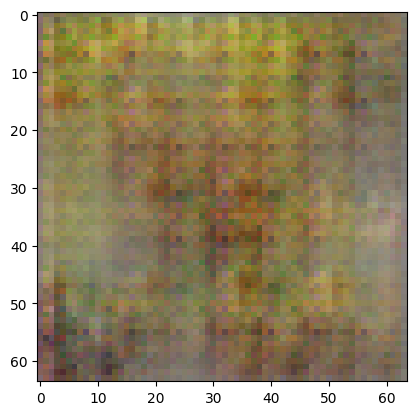

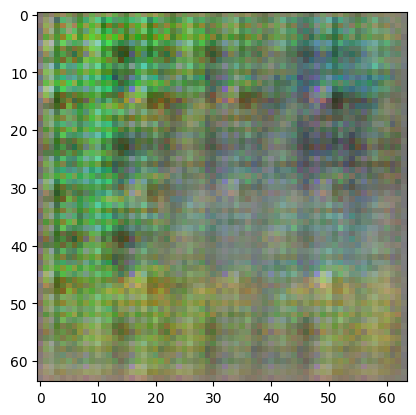

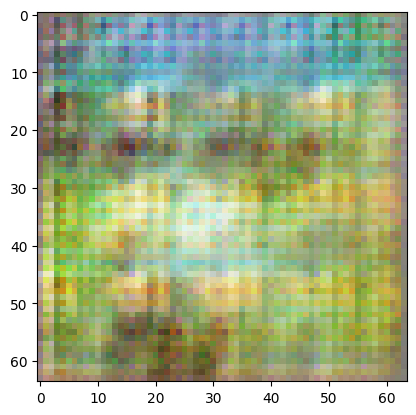

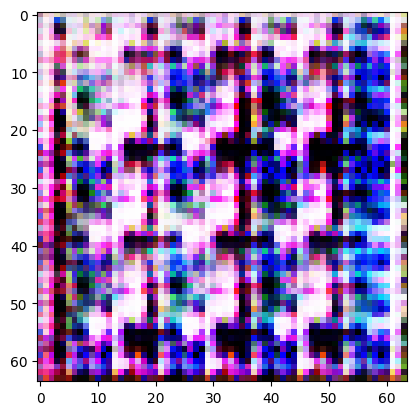

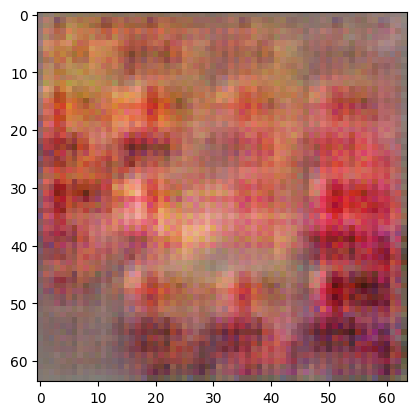

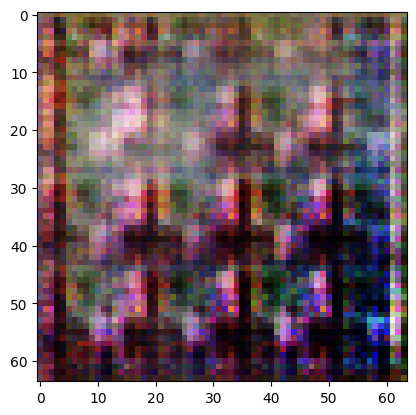

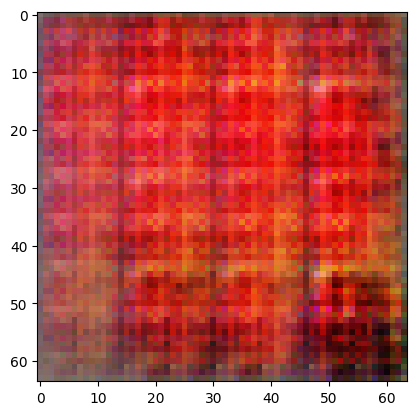

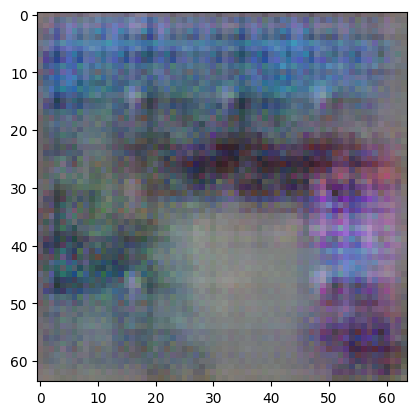

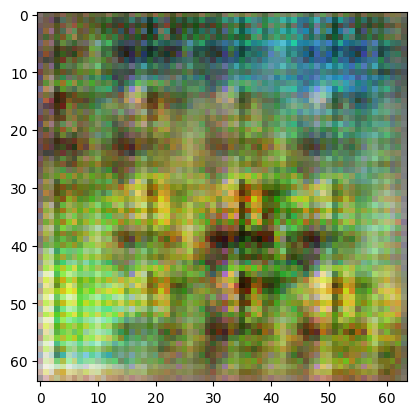

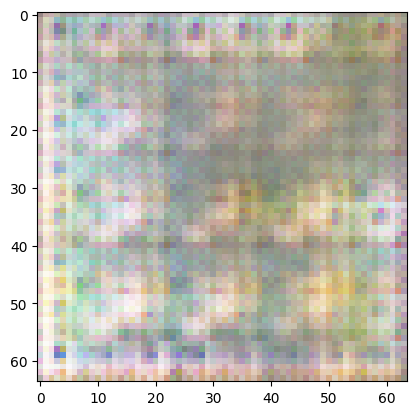

In [43]:
# generate ten images
generator.eval()
generated_images = generator(torch.randn(10, 100, 1, 1).to('cuda')).detach().cpu().numpy()

# print image
for image in generated_images:
    image = (image + 1) / 2
    image = np.transpose(image.squeeze(), (1, 2, 0))
    plt.imshow(image)
    plt.show()

In [44]:
generated_images.min(), generated_images.mean(), generated_images.max()

(-0.99998003, -0.052991383, 0.99999374)